In [1]:
import torch, json, os, gc
import numpy as np
from torch.utils.data import DataLoader, SubsetRandomSampler
from utils.imagedata import SpectrumImageDataset, collate_fn
from utils.spectrum import read_spectrum, save_spectrum, denorm_spectrum
from utils.trainer import DBPNTrainer
from dbpn.dbpn_iterative import Net as DBPNITERNet
from dbpn.dbpn_iterative_pool import Net as DBPNITERNetPool

In [96]:
input_file = '376.txt'
target_file = '375.txt'
input_root = './example_data/'
input_root = '/home/jhyang/WORKSPACES/DATA/2D/pl_postech/spectrum/'
batch_size = 8
target_resolution = 100
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = 'cpu'

In [100]:
dataset2 = SpectrumImageDataset(upscale_factor=2, data_augmentation=False)
dataset4 = SpectrumImageDataset(upscale_factor=4, data_augmentation=False)
dataset8 = SpectrumImageDataset(upscale_factor=8, data_augmentation=False)

model1 = DBPNITERNet(num_channels=3, base_filter=64, feat=256, num_stages=3, scale_factor=4)
pt_dict1 = torch.load('./dbpn/models/DBPN-RES-MR64-3_4x.pth', map_location='cpu')

model2 = DBPNITERNetPool(num_channels=3, base_filter=64, feat=256, num_stages=3, scale_factor=4)
pt_dict2 = torch.load('/home/jhyang/WORKSPACES/MODELS/super_res/pl/all/dbpnv3x4/00005.model.th', map_location='cpu')

model3 = DBPNITERNet(num_channels=3, base_filter=64, feat=256, num_stages=3, scale_factor=2)
pt_dict3 = torch.load('./dbpn/models/DBPN-RES-MR64-3_2x.pth', map_location='cpu')

model4 = DBPNITERNetPool(num_channels=3, base_filter=64, feat=256, num_stages=3, scale_factor=2)
pt_dict4 = torch.load('/home/jhyang/WORKSPACES/MODELS/super_res/pl/all/dbpnv3/00005.model.th', map_location='cpu')

model5 = DBPNITERNet(num_channels=3, base_filter=64, feat=256, num_stages=3, scale_factor=8)
pt_dict5 = torch.load('./dbpn/models/DBPN-RES-MR64-3_8x.pth', map_location='cpu')

trainers = {}
for k, model, pt_dict, ds in [
        ('pt2x', model3, pt_dict3, dataset2), 
        ('ft2x', model4, pt_dict4, dataset2),
        ('pt4x', model1, pt_dict1, dataset4), 
        ('ft4x', model2, pt_dict2, dataset4), 
        ('pt8x', model5, pt_dict5, dataset8)
    ]:
    pt_dict = {k.replace('module.',''):v for k,v in pt_dict.items()}
    md_dict = model.state_dict()
    md_dict.update(pt_dict)
    model.load_state_dict(md_dict)
    model.to(device)
    trainers[k] = DBPNTrainer(model=model, opt=None, residual=True, device=device), ds

100%|██████████| 5/5 [01:12<00:00, 14.49s/it]


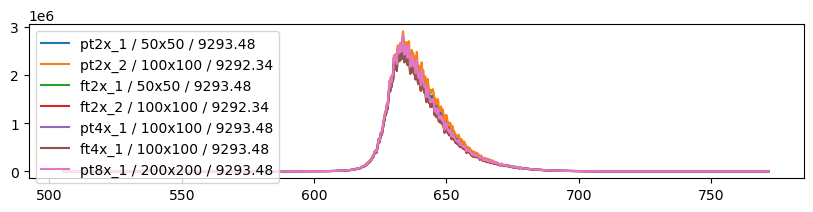

In [101]:
outputs = {'inp':read_spectrum(input_file, root=input_root),
           'tgt':read_spectrum(target_file, root=input_root)}
outputs['bic'] = outputs['inp'][0], torch.nn.functional.interpolate(torch.tensor(outputs['inp'][1]).unsqueeze(0), scale_factor=4, mode='bicubic')[0].numpy()
import matplotlib.pyplot as plt
import tqdm
f, ax = plt.subplots(1,1,figsize=(10,2))
for k, (trainer, ds) in tqdm.tqdm(trainers.items()):
    x, ys = outputs['inp']
    n0 = ys.shape[1]
    for i in range(1, 20):
        gc.collect()
        torch.cuda.empty_cache()
        ds.from_data(x, ys)
        data_loader = DataLoader(ds, batch_size=batch_size, collate_fn=collate_fn)
        out = trainer.pred(data_loader)['None_None']
        x = out['x']
        ys = denorm_spectrum(out['pred'], out['vmin'], out['vmax'])
        n = ys.shape[1]
        ax.plot(x, np.var(ys.reshape(x.shape[0], -1), axis=1), label=f'{k}_{i} / {n}x{n} / {out["vmax"]:.2f}')
#        print(k, i, ys.shape, n0, 4 ** i, '\t x: {:.2f} ~ {:.2f} / y: {:.2f} ~ {:.2f}'.format(x[0], x[-1], out['vmin'], out['vmax']))
        
        outputs[f'{k}_{i}'] = x,ys,out
        if ys.shape[1] >= target_resolution:
            break
_ = ax.legend(loc='upper left')

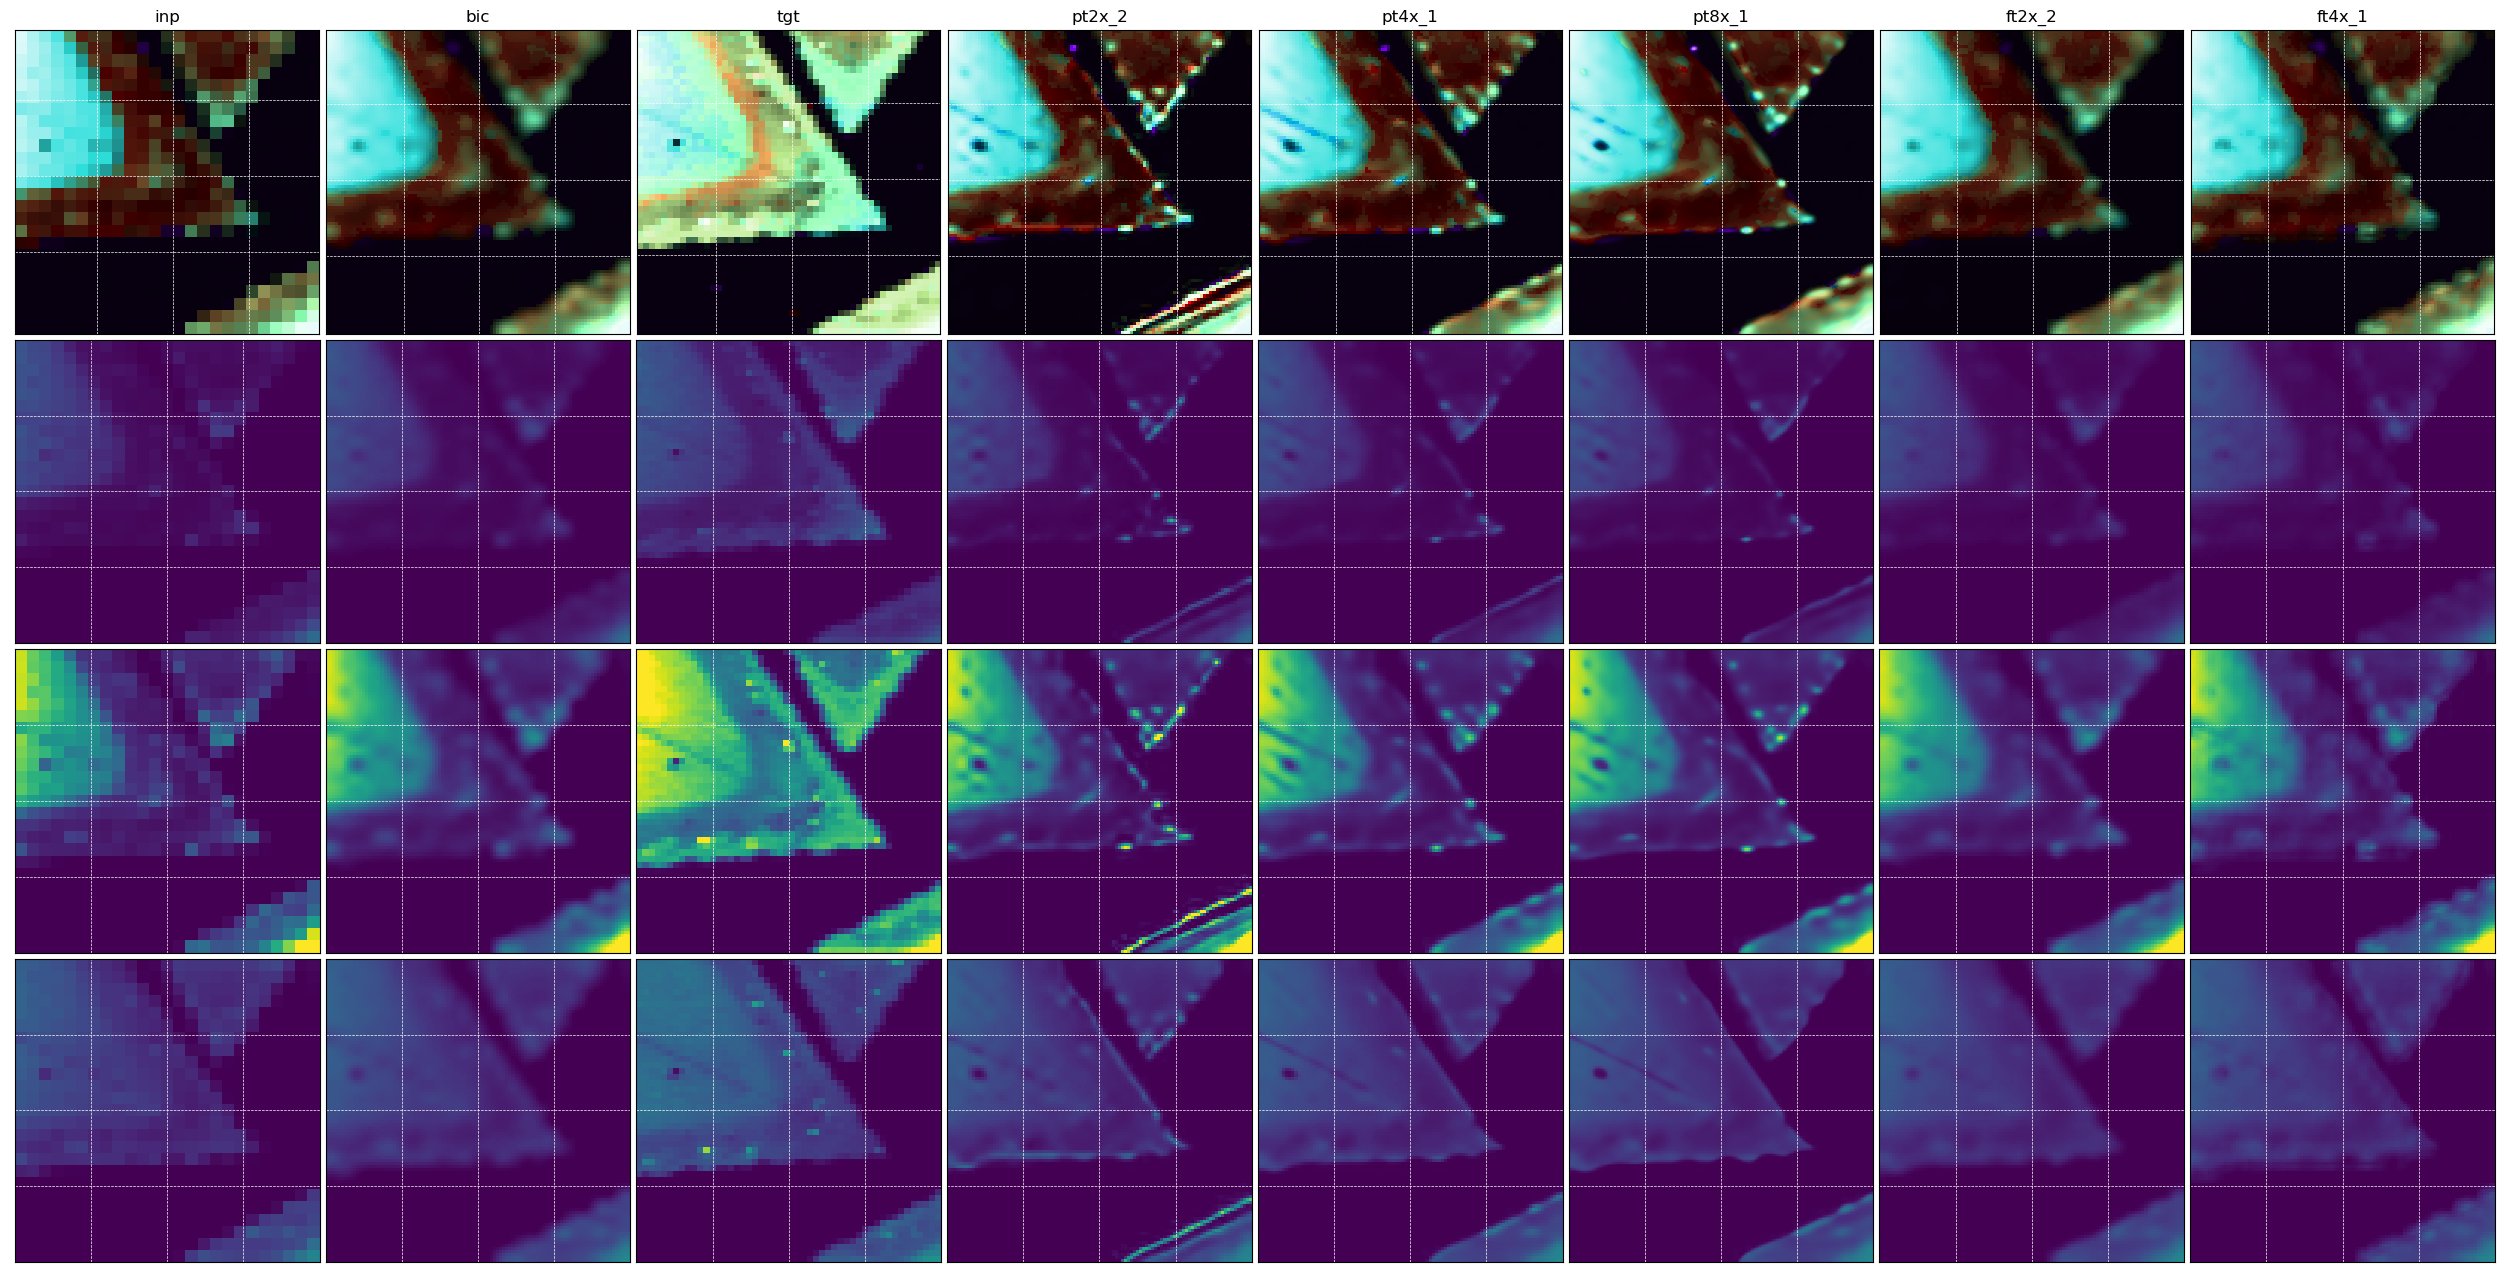

In [107]:
import matplotlib.pyplot as plt
from utils.visualize import plot_map, plot_maxmap
locs = [620, 640, 660]
vmin, vmax = 740, 7000
sfxs = [2, 1, 1]
keys = ['inp','bic','tgt', f'pt2x_{sfxs[0]}', f'pt4x_{sfxs[1]}', f'pt8x_{sfxs[2]}', f'ft2x_{sfxs[0]}', f'ft4x_{sfxs[1]}']
f, axs = plt.subplots(1+len(locs),len(keys), figsize=(len(keys) * 4, 4*len(locs) + 4))
for ax, k in zip(axs.T, keys):
    v = outputs[k]
    plot_maxmap(ax[0], v[0], v[1], xrange=[np.min(locs), np.max(locs)], yrange=[vmin, vmax])
    ax[0].set_title(k)
    for _ax in ax:
        for r in [0.25, 0.5, 0.75]:
            _ax.axvline(v[1].shape[1] * r, ls='--', lw=0.5, color=[1,1,1])
            _ax.axhline(v[1].shape[1] * r, ls='--', lw=0.5, color=[1,1,1])
    for i, loc in enumerate(locs):
        plot_map(ax[i+1], v[0], v[1], loc=loc, tol=0.1, vmin=vmin, vmax=vmax)
f.subplots_adjust(wspace=0.02, hspace=0.02)

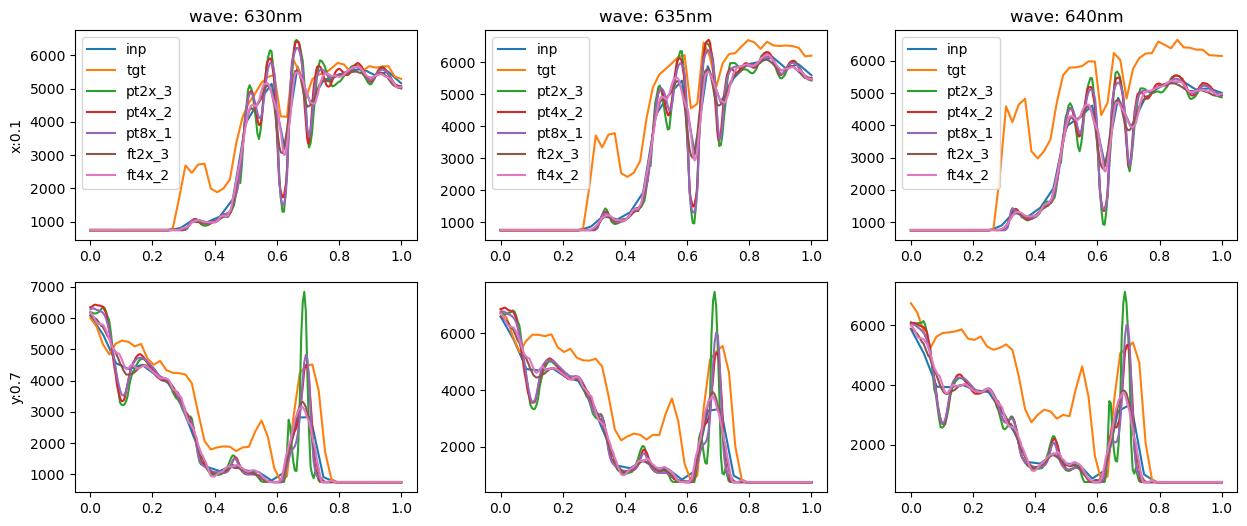

In [83]:
slices = {'x':[0.1], 'y':[0.7]}
f, axs = plt.subplots(len(slices['x']) + len(slices['y']),len(locs), figsize=(5*len(locs), 3*(len(slices['x']) + len(slices['y']))))
for key in keys:
    x, y = outputs[key][:2]
    n = y.shape[1]
    lx = np.linspace(0,1,n)
    for loc, ax in zip(locs, axs.T):
        j = 0
        i = np.argmin(np.abs(x - loc))
        m = y[i].copy()
        ax[0].set_title(f'wave: {loc}nm')
        for fx in slices['x']:
            h = int(n * fx)
            ax[j].plot(lx, m[:, h], label=key)
            if loc == locs[0]:
                ax[j].set_ylabel(f'x:{fx}')
            j += 1
        for fy in slices['y']:
            h = int(n * fy)
            ax[j].plot(lx, m[h, :], label=key)
            if loc == locs[0]:
                ax[j].set_ylabel(f'y:{fy}')
            j += 1
        ax[0].legend(loc='upper left')
        
        
    

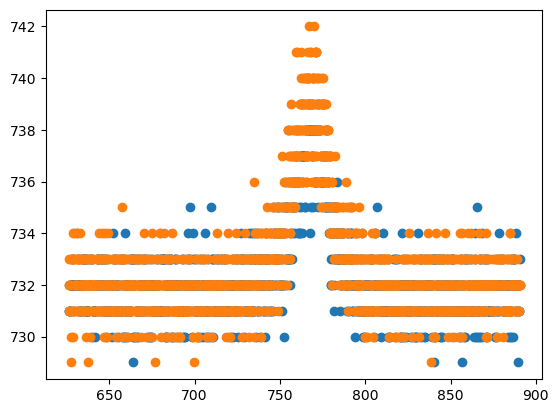

In [54]:
cmap = plt.get_cmap('rainbow')
x0, y0 = outputs['inp'][:2]
x1, y1 = outputs['tgt'][:2]
plt.scatter(x0, y0.transpose(1,2,0)[5,5])
plt.scatter(x1, y1.transpose(1,2,0)[10,10])
#cmap(1-1e-5)

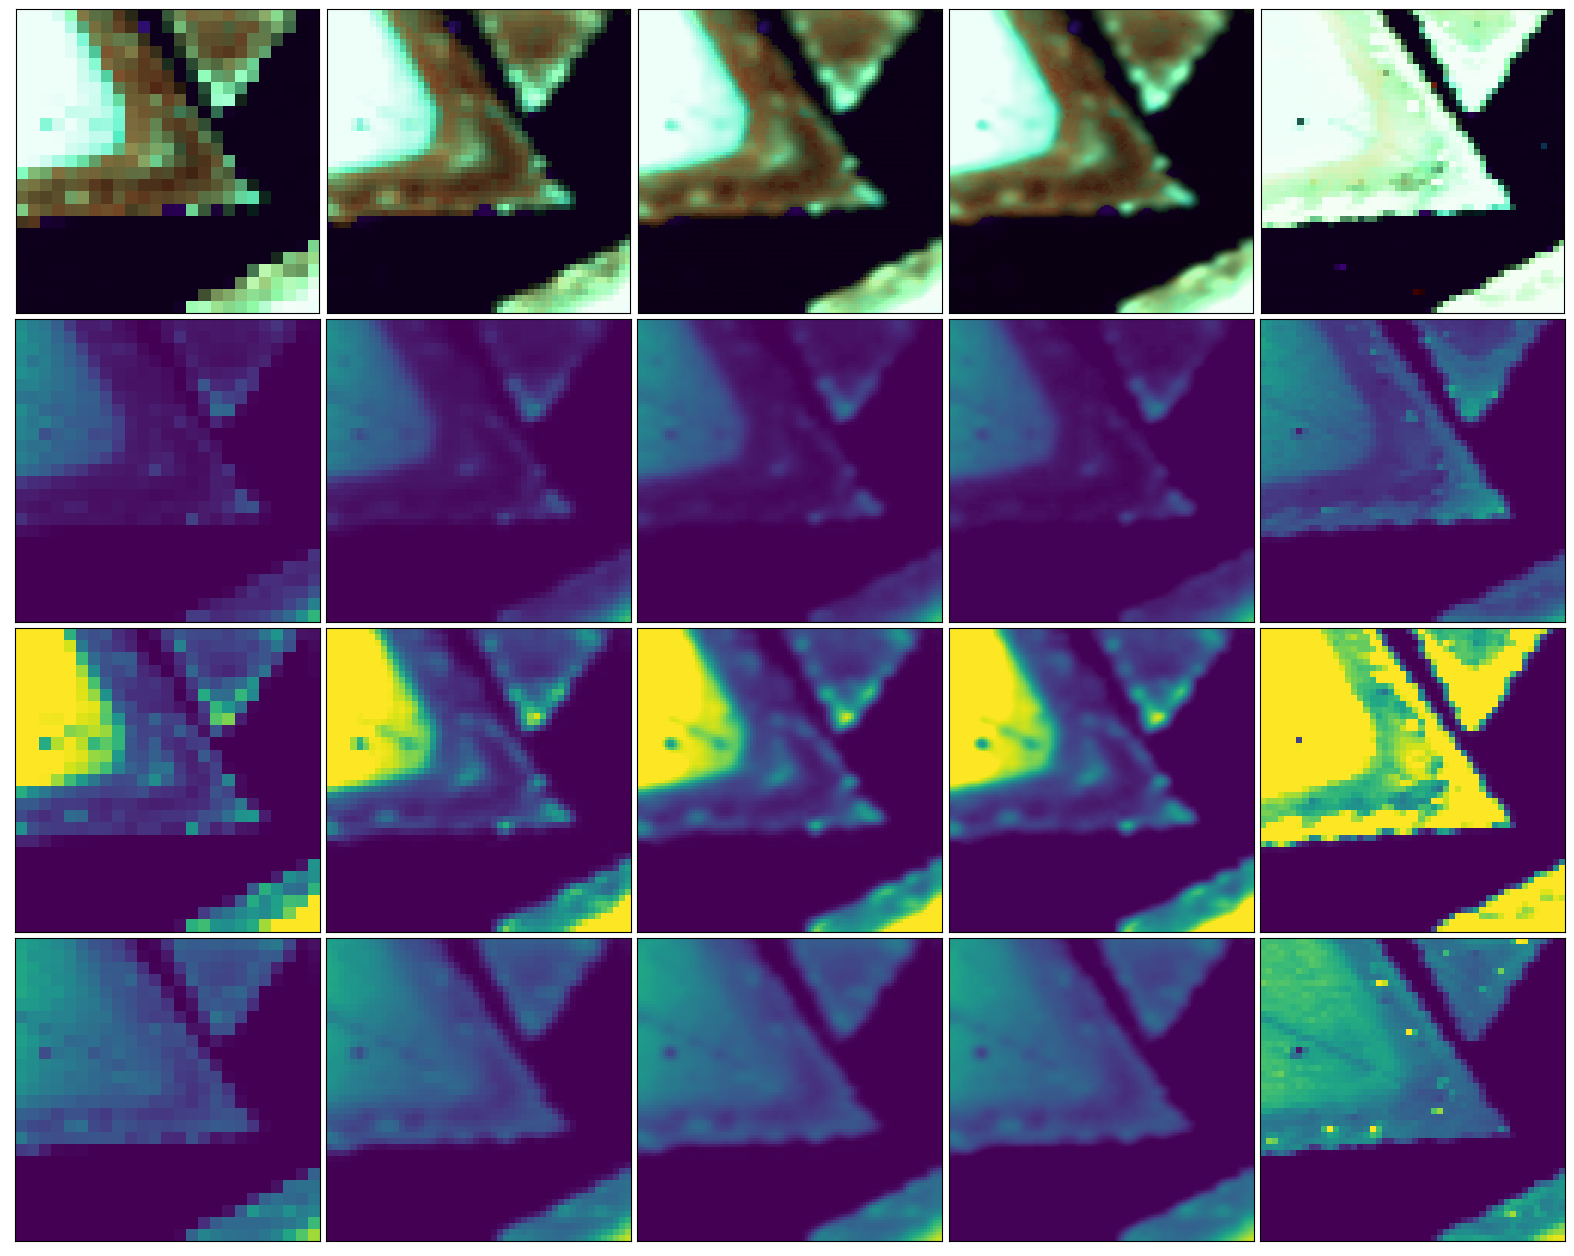

In [20]:
import matplotlib.pyplot as plt
from utils.visualize import plot_map, plot_maxmap
locs = [620, 640, 660]
f, axs = plt.subplots(1+len(locs),len(outputs_2x), figsize=(len(outputs_2x) * 4, 4*len(locs) + 4))
for ax, v in zip(axs.T, outputs_2x.values()):
    x, y = v[:2]
    plot_maxmap(ax[0], x, y, xrange=[600, 680], yrange=[740,4000])
    for i, loc in enumerate(locs):
        plot_map(ax[i+1], x, y, loc=loc, tol=0.1, vmin=740, vmax=4000)
f.subplots_adjust(wspace=0.02, hspace=0.02)

In [ ]:
if not input_file.endswith('.txt'):
    input_file += '.txt'
output_file = input_file.replace('.txt','_x.txt')


out['pred']

r0 = v['pred'].shape[-1]
key = k.split('_')[1] if k.startswith('None') else k.split('_')[0]
x = output['x']
r0 = output['pred'].shape[1]
xs_ref = valid_DS.xs[key]

for i in range(1, 10):
    f = p.upscale_factor ** (i)
    print('{} \t {} \t {}'.format(k, f * p.upscale_factor, f * r0))
    ys = denorm_spectrum(ys, output=['pred'], vmin=output['vmin'], vmax=output['vmax'])
    test_DS.from_data(x, ys, xs_ref)
    test_dl = DataLoader(test_DS, batch_size=p.batch_size, collate_fn=collate_fn)
    output = trainer.pred(test_dl)['None_None']
    save_data(k=k, root='/home/jhyang/WORKSPACES/MODELS/super_res/pl/cs/s80/dbpn/finetune/s00_2x/00030.output',
                sfx=f'{f*p.upscale_factor}x', data=output)
    if r0 * f >= p.max_upscale_res:
        break
        

123.68215
19.778433
21.208195


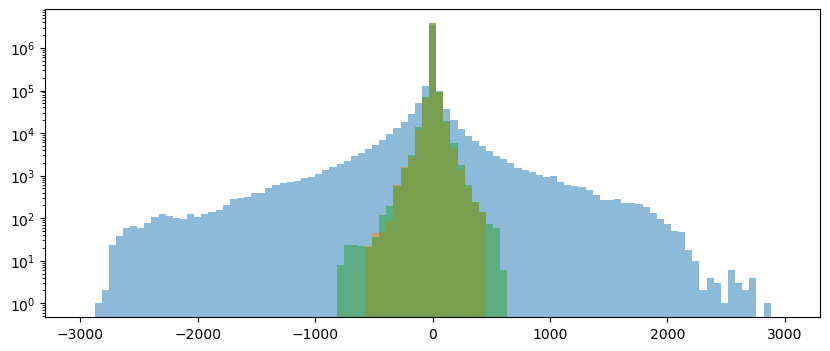

In [48]:

import matplotlib.pyplot as plt

f, ax = plt.subplots(1,1,figsize=(10,4))
for out in [output, output_10, output_20]:
    vmin = out['None_None']['vmin']
    vmax = out['None_None']['vmax']
    x = out['None_None']['x']
    pred = out['None_None']['pred']
    bic = out['None_None']['bic']

    diff = (denorm_spectrum(bic, vmin, vmax) - denorm_spectrum(pred, vmin, vmax)).reshape(-1)
    ax.hist(diff, bins=np.linspace(-3000,3000,100), alpha=0.5)
    print(np.std(diff))
    ax.set_yscale('log')    

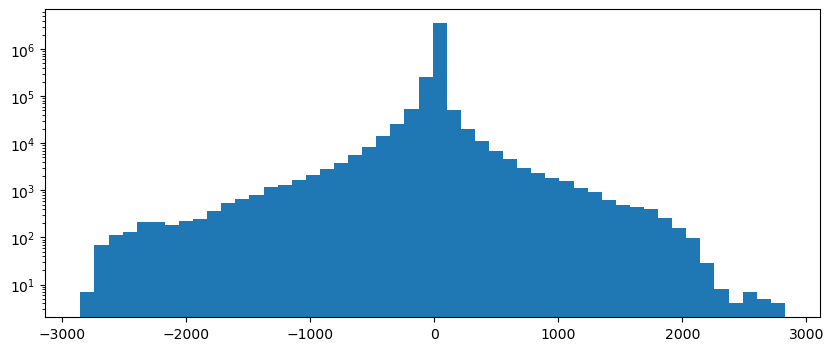

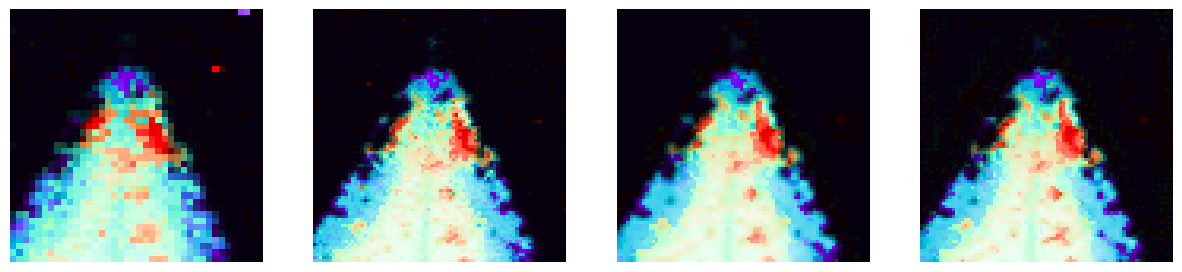

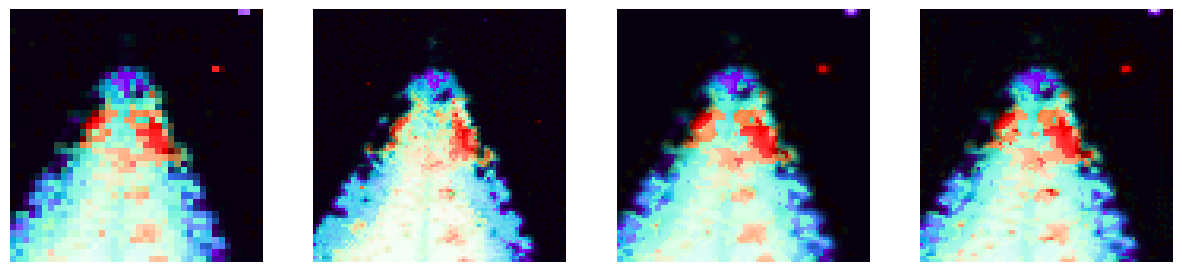

In [53]:
from utils.spectrum import read_spectrum
from utils.visualize import plot_map, plot_maxmap
import matplotlib.pyplot as plt

x674, ys674 = read_spectrum(674)
x676, ys676 = read_spectrum(676)

for k, v in valid_outputs[10].items():
    f, axs = plt.subplots(1,4,figsize=(15, 4))
    a = v['vmax'] - v['vmin']
    b = v['vmin']
    plot_maxmap(axs[0], x674, ys674, xrange=[630, 640], yrange=[v['vmin'], v['vmax']])
    plot_maxmap(axs[1], x676, ys676, xrange=[630, 640], yrange=[v['vmin'], v['vmax']])
    plot_maxmap(axs[2], v['x'], v['bic'] * a + b, xrange=[630, 640], yrange=[v['vmin'], v['vmax']])
    plot_maxmap(axs[3], v['x'], v['pred'] * a + b, xrange=[630, 640], yrange=[v['vmin'], v['vmax']])

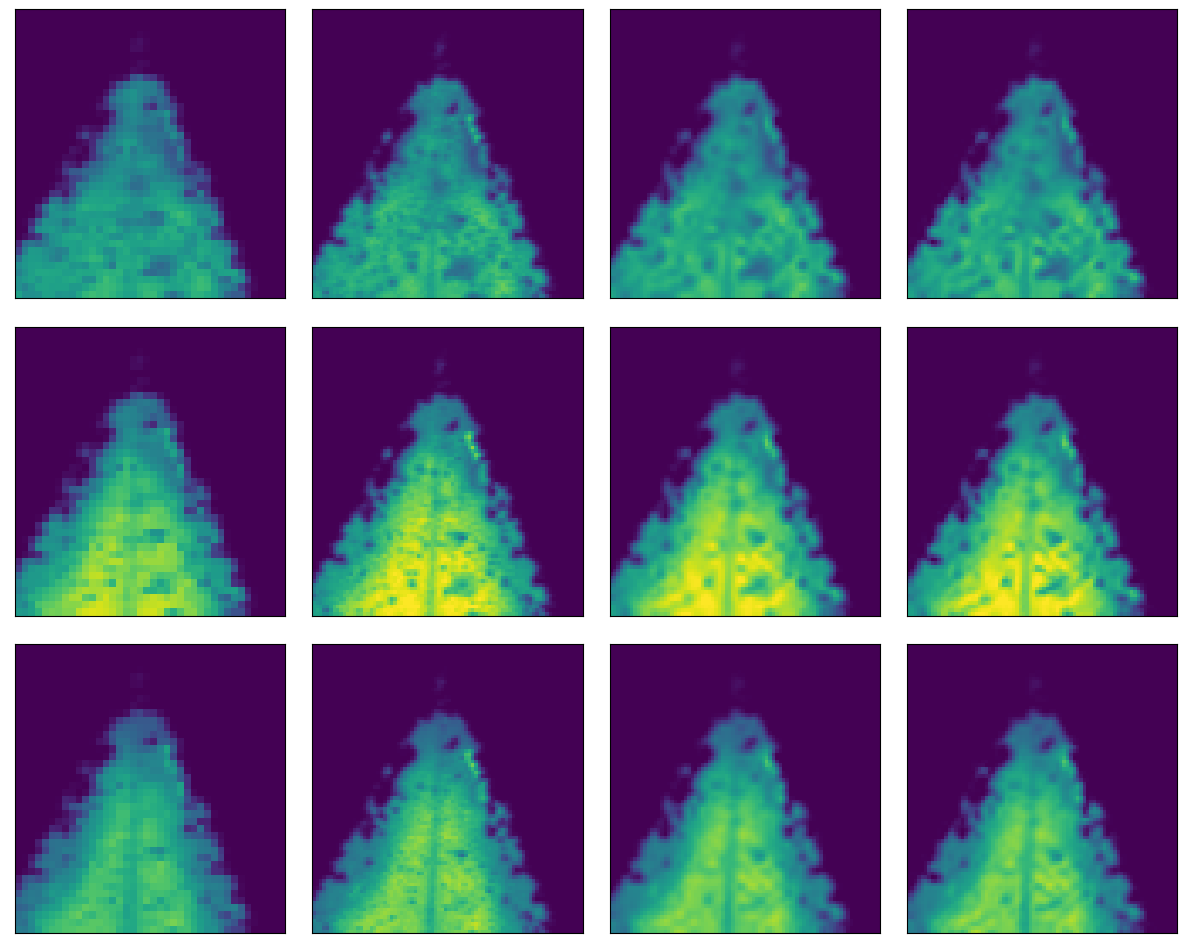

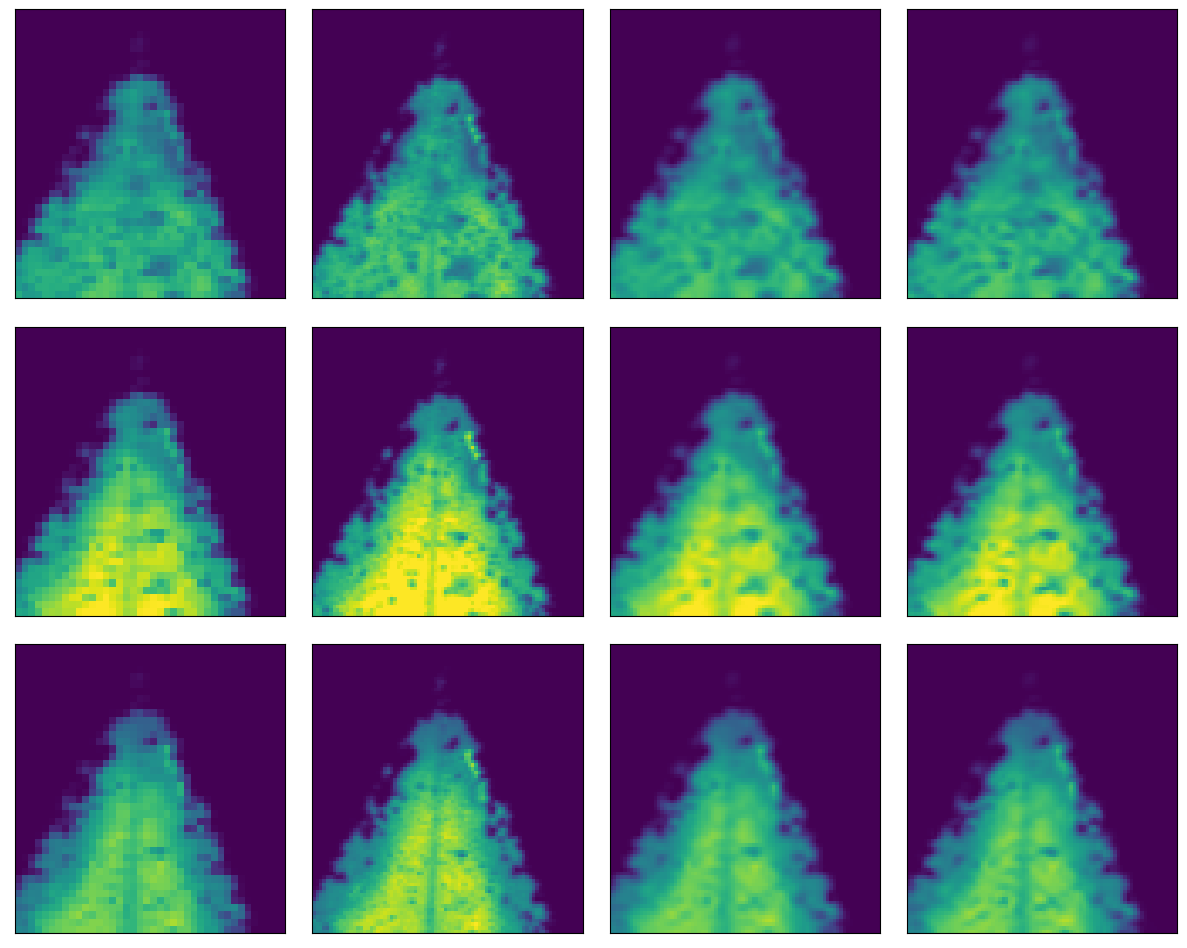

In [59]:
for k, v in valid_outputs[10].items():
    f, axs = plt.subplots(3,4,figsize=(15, 12))
    a = v['vmax'] - v['vmin']
    b = v['vmin']
    locs = [630, 635, 640]
    for loc, ax in zip(locs, axs):
        plot_map(ax[0], x674, ys674, loc=loc, tol=0.5, vmin=v['vmin'], vmax=v['vmax'])
        plot_map(ax[1], x676, ys676, loc=loc, tol=0.5, vmin=v['vmin'], vmax=v['vmax'])
        plot_map(ax[2], v['x'], v['bic'] * a + b, loc=loc, tol=0.5, vmin=v['vmin'], vmax=v['vmax'])
        plot_map(ax[3], v['x'], v['pred'] * a + b, loc=loc, tol=0.5, vmin=v['vmin'], vmax=v['vmax'])
    f.subplots_adjust(wspace=0.1, hspace=0.1)

In [9]:
for k, v in valid_output.items():
    r0 = v['pred'].shape[-1]
    key = k.split('_')[1] if k.startswith('None') else k.split('_')[0]
    x = output['x']
    r0 = output['pred'].shape[1]
    xs_ref = valid_DS.xs[key]

    for i in range(1, 10):
        f = p.upscale_factor ** (i)
        print('{} \t {} \t {}'.format(k, f * p.upscale_factor, f * r0))
        ys = denorm_spectrum(ys, output=['pred'], vmin=output['vmin'], vmax=output['vmax'])
        test_DS.from_data(x, ys, xs_ref)
        test_dl = DataLoader(test_DS, batch_size=p.batch_size, collate_fn=collate_fn)
        output = trainer.pred(test_dl)['None_None']
        save_data(k=k, root='/home/jhyang/WORKSPACES/MODELS/super_res/pl/cs/s80/dbpn/finetune/s00_2x/00030.output',
                  sfx=f'{f*p.upscale_factor}x', data=output)
        if r0 * f >= p.max_upscale_res:
            break
        

671_None (512, 10, 10)
4 20
8 40
16 80
32 160
672_None (512, 20, 20)
4 40
8 80
16 160
673_None (512, 40, 40)
4 80
8 160


In [13]:
output_path = os.path.join(p.output_path, p.tag)

os.listdir(output_path )

['bic.674_676_2x.txt',
 '00080.output',
 '00040.output',
 '00030.output',
 'output',
 '00050.output',
 '00090.model.th',
 '00100.model.th',
 'events.out.tfevents.1673359462.jhyangws2.2759422.0',
 '00020.output',
 '00040.model.th',
 '00050.model.th',
 '00010.model.th',
 '00010.output',
 '00060.output',
 '00070.model.th',
 '00070.output',
 '00030.model.th',
 '00090.output',
 '00100.output',
 '00080.model.th',
 'bic.None_676_2x.txt',
 '00060.model.th',
 '00020.model.th']